## General WorkFlow of GSA in CGH

Given an input amplitude $A_0(t)$ and the desired spectrum $S(\omega)$, GSA gives out workflow approaching $S(\omega)$ iteratively,

1. In time domain there is signal $A_0(t)e^{i\phi_j(t)}$. The signal then propagate through Fourier Transform and obtianed the transform result $\mathscr{F}[A_0(t)\exp(i\phi_j(t))] = \tilde{A}_{j+1}(\omega)\exp(i\tilde{\phi}_{j+1}(\omega))$.

2. Then transformed amplitude is discarded, acting the phase on the transformation of original amplitude, then obtain a new signal $\tilde{A}_0(\omega)\exp(i\tilde{\phi}_{j+1}(\omega))$.

3. Once again, the obtain signal propagate through an inverse Fourier Transformation and results in $\mathscr{F}^{-1}[\tilde{A}_0(\omega)\exp(i\tilde{\phi}_j(\omega))] = A_{j+1}(t)\exp(i\phi_{j+1}(t))$.

4. The amplitude is also discarded. The phase acting on the original amplitude, we obtain $A_0(t)\exp(i\phi_{j+1}(t))$.

The whole process is repeated and the phase modulation is updated incremently. Also notice that in one cycle of these operations, the difference between the obtain signal and target signal is measured. The whole process is repeated until the error (difference) is below the predetermined tolerance or maximum times of interation exceeds.The function then output the latest version of phase modulation $\phi(t)$.

In actual practice, we need to consider linear and nonlinear electronic effects, as well as chromatic dispersion. Linear effect can be modeled as transfer function and hence can be compensate, while feasible methods to compensate for nonlinear effects have not yet been found, the effort mainly focus on minimizing these non-linear electronic effects.

In [137]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

Following functions provides basic operations in our algorithm and analysis. First we define the core of our algorithm: fourier transform and its inverse.

## Fourier Transform

In [138]:
# Forward Fourier Transform

def fourier_transformt(A_t, phi_t):
    # 构建频域信号
    signal = A_t * np.exp(1j * phi_t)
    
    # 傅里叶变换到时域
    time_signal = np.fft.fft(signal)
    
    # 提取时域信号的幅度和相位
    A_w = np.abs(time_signal)

    phi_w = np.angle(time_signal)
    
    return A_w, phi_w

# Inverse Fourier Transform

def fourier_transform(A_w, phi_w):
    
    # 构建频域信号
    signal = A_w * np.exp(1j * phi_w)
    
    # 傅里叶变换到时域
    time_signal = np.fft.ifft(signal)
    
    # 提取时域信号的幅度和相位
    A_t = np.abs(time_signal)

    phi_t = np.angle(time_signal)
    
    return A_t, phi_t

GSA is iterative, and a measurement is needed to determine the error between the generated spectra and target spectra.

## Error Measurement

In [139]:
def calculate_mse(signal1, signal2):
    # 确保信号长度相同
    if len(signal1) != len(signal2):
        raise ValueError("信号长度不一致")

    # 计算均方误差
    mse = np.mean((signal1 - signal2)**2)

    return mse

Our analysis is mainly achieved by phase plot in both frequency and time domain.

## Frequency Plot

In [140]:
def plot_frequency_domain(A_w, phi_w):

    # 绘制频域信号的幅度和相位
    plt.figure(figsize=(12, 4))
    # 幅度图
    plt.subplot(1, 2, 1)
    plt.plot(f, A_w)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Amplitude in Frequency Domain')

    # 相位图
    plt.subplot(1, 2, 2)
    plt.plot(f, phi_w)
    plt.xlabel('Frequency')
    plt.ylabel('Phase')
    plt.title('Phase in Frequency Domain')

    # 调整子图之间的间距
    plt.tight_layout()

    # 展示图形
    plt.show()

Now for testing, we define a function generate Gaussian light:

## Gaussian Light Generation:

In [141]:
def Gaussian_Light(mu, sigma, freq):
    return 1./ np.sqrt(2 * sigma) * np.exp(-(freq - mu)**2. /(2 * sigma**2. ))

The following cell testing the Gaussian Light Function

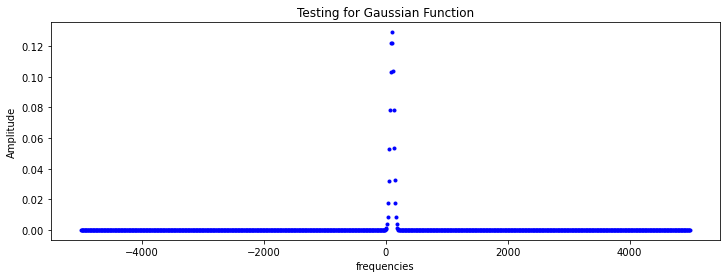

In [142]:
# Testing, not use for main function

T=0.1
t = np.linspace(0, T, 1000)
amplitude = complex(1, 0)  # 复振幅的实部和虚部
phit = np.zeros(1000)
signal = amplitude * np.exp(1j*(phit))

# 进行离散傅里叶变换
X = np.fft.fft(signal)

# 生成频率轴
N = len(signal)  # 信号的长度
dt = t[1]-t[0]
freqs = np.fft.fftfreq(N, dt)

mu = 100  # 均值
sigma = 30  # 标准差

testing = Gaussian_Light(mu, sigma, freqs)

plt.figure(figsize=(12, 4))
plt.plot(freqs,testing, 'b.')
plt.xlabel("frequencies")
plt.ylabel("Amplitude")

plt.title("Testing for Gaussian Function")
plt.show()

The workflow of the algorithm is executed by the main function.

## Main Function

In [143]:
def main(T, N, num_iterations, amplitude_spectrum_0, phase_spectrum_0, signal):
    '''
    Input:
        T: duration of analysis
        N: number of sampling points
        num_iterations: number of iterations
        amplitude_spectrum_0: amplitude spectrum of target spectrum
        phase_spectrum_0: phase spectrum of target spectrum
        signal: input signal to be modulated
        
    Output:
        t: time interval for analysis
        amplitude_spectrum: Amplitude spectrum of modulated signal 
        phase_spectrum: Phase spectrum of modulated signal
        A_t: Required amplitude modulation of signal
        phi_t: Required phase modulation of signal
        errors: error between target spectrum and iterative signals
    '''
    # Initializations
    t = np.linspace(0, T, N)
    dt = t[1] - t[0]
    errors = []
    
    # Initialize a spectrum for amplitude
    X = np.fft.fft(signal)
    amplitude_spectrum = np.abs(X)
    phase_spectrum = np.angle(X)
    
    # Iterative Process
    for i in range(num_iterations):
        
        # Collecting Errors in the Progress
        error = calculate_mse(amplitude_spectrum, amplitude_spectrum_0)
        errors.append(error)
        
        # Obtain Signal in Time Domain
        amplitude_spectrum = amplitude_spectrum_0
        A_t, phi_t = fourier_transform(amplitude_spectrum_0, phase_spectrum)
        
        # Obtain Spectrum in Frequency Domain
        At_in = np.mean(A_t)
        A_t=At_in* np.ones_like(A_t)
        amplitude_spectrum, phase_spectrum = fourier_transformt(A_t, phi_t)
        
        # Incrementing Iterative Index
        i += 1
        
    return t, amplitude_spectrum, phase_spectrum, A_t, phi_t, errors

In practice, we need to define signal in time domain for main function.

## Input Signal Generation (Time Domain)

In [212]:
def signal(T, N):
    '''
    Input:
        T: Duration for Analysis
        N: Number of Points for Sampling
        
    Output:
        signal_out: generated signal
        phit: phase of generated signal
    '''
    signal_out = np.zeros(N)
    
    '''
    ### Default signal
    amplitude = complex(1, 0)
    phit = np.zeros(N)
    signal = amplitude * phit
    '''
    
    ### Define Signal below
    amplitude = complex(1, 0)
    phit = np.zeros(N)
    signal_out = amplitude * np.exp(1j * phit)
    ###
    
    return signal_out, phit

For testing purpose, we plot the input signal.

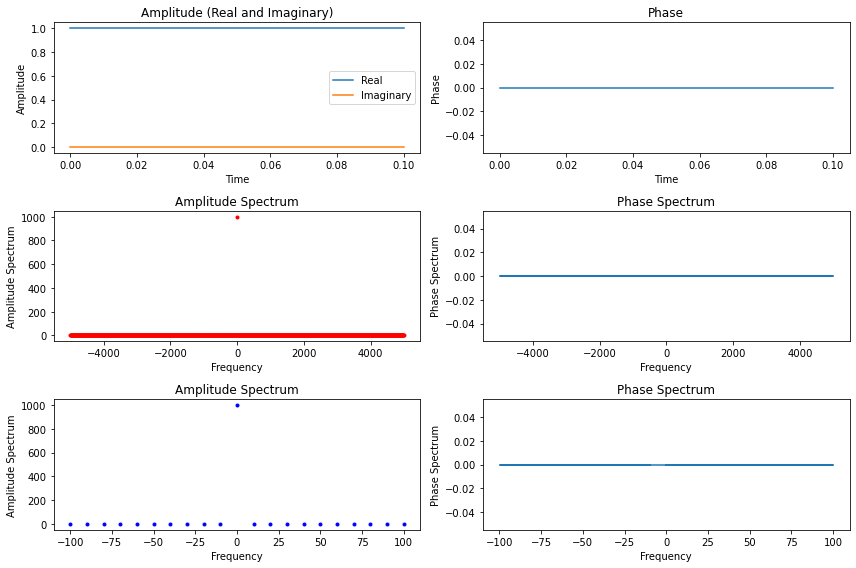

In [196]:
signal_t, phit = signal(0.1, 1000)
t = np.linspace(0, 0.1, 1000)
signal_w = np.fft.fft(signal_t)
freqs = np.fft.fftfreq(1000, t[1] - t[0])


amplitude_spectrum = np.abs(signal_w)
phase_spectrum = np.angle(signal_w)

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(t, signal_t.real, label='Real')
plt.plot(t, signal_t.imag, label='Imaginary')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude (Real and Imaginary)')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, phit)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Phase')

plt.subplot(3,2,3)
plt.plot(freqs, amplitude_spectrum,'r.')
plt.xlabel('Frequency')
plt.ylabel('Amplitude Spectrum')
plt.title('Amplitude Spectrum')

plt.subplot(3,2,4)
plt.plot(freqs, phase_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Phase Spectrum')
plt.title('Phase Spectrum')


freq_range = (-100, 100)
freq_mask = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])

plt.subplot(3,2,5)
plt.plot(freqs[freq_mask], amplitude_spectrum[freq_mask], 'b.')
plt.xlabel('Frequency')
plt.ylabel('Amplitude Spectrum')
plt.title('Amplitude Spectrum')

plt.subplot(3,2,6)
plt.plot(freqs[freq_mask], phase_spectrum[freq_mask])
plt.xlabel('Frequency')
plt.ylabel('Phase Spectrum')
plt.title('Phase Spectrum')

plt.tight_layout()
plt.show()

We also need to define the target sepctrum.

## Input Target Spectrum

In [197]:
def spectrum_generation(freqs):
    '''
    Input:
        freqs: ndarray, frequency range for spectrum generation
        
    Output:
        Amplitude: ndarray, Generated Amplitude Spectrum
        Phase: ndarray, Generated Phase Spectrum
    '''
    # Initialization to zeros
    Phase = np.zeros(len(freqs))
    Amplitude = np.zeros(len(freqs))
    Signal_w = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    
    # Default: Supperposition of Four Gaussian Lights 
    Amplitude = 0.4 * Gaussian_Light(0, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    Signal_w = [Signal_w[i] + c[i] for i in range(len(freqs))]
    
    Amplitude = Gaussian_Light(600, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    Signal_w = [Signal_w[i] + c[i] for i in range(len(freqs))]
    
    Amplitude = Gaussian_Light(-600, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    Signal_w = [Signal_w[i] + c[i] for i in range(len(freqs))]
    
    Amplitude = 0.6 * Gaussian_Light(-480, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    Signal_w = [Signal_w[i] + c[i] for i in range(len(freqs))]
    
    Amplitude = np.abs(Signal_w)
    Phase = np.angle(Signal_w)
    return Amplitude, Phase

We also perform testing in spectrum generation.

In [198]:
freqs = np.linspace(-1200, 1200,1000)
a, s = spectrum_generation(freqs)

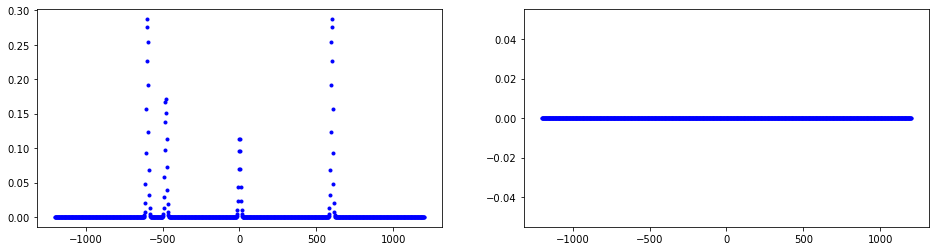

In [199]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(freqs, a, 'b.')

plt.subplot(1,2,2)
plt.plot(freqs, s, 'b.')

plt.show()

Here we define input parameters of our main function.

## Input Parameter Setting

In [213]:
T = 0.25  # Time range
N = 10000  # Number of Sampling points
t = np.linspace(0, T, N)
num_iterations = 2000

# Generate frequency range
w = np.fft.fftfreq(N, t[1]-t[0])

# Define signal in time Domain
signal,_ = signal(T, N)

# Define Target Spectrum
amplitude_spectrum_0, phase_spectrum_0 = spectrum_generation(w)

## Executing the main function

In [214]:
t, amplitude_spectrum, phase_spectrum, A_t, phi_t, errors = main(T, N, num_iterations, amplitude_spectrum_0, phase_spectrum_0, signal)

Here we analyze the convergence plot.

## Convergence Plot

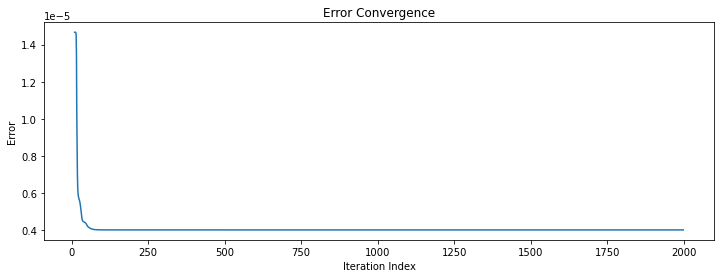

In [215]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(num_iterations))[10:], errors[10:])
plt.xlabel('Iteration Index')
plt.ylabel('Error')
plt.title('Error Convergence')
plt.show()

Here we plot the phase and amplitude functions in time and frequency domains.

## Phase and Amplitude Plot

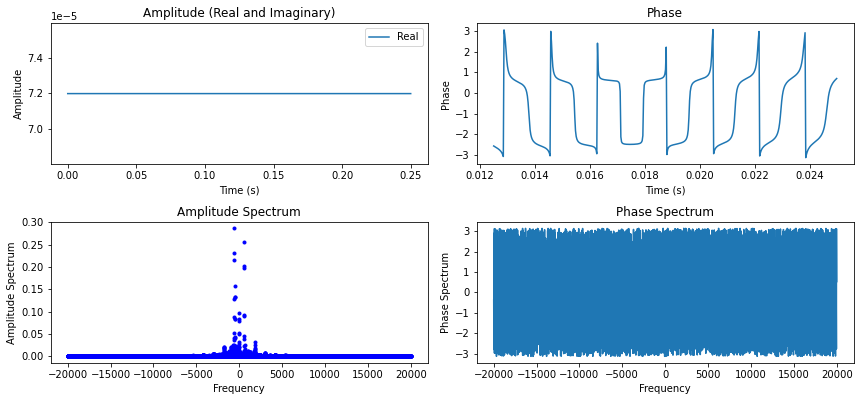

In [216]:
freq_range = (-1200, 1200)
freq_mask = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])

plt.figure(figsize=(12, 8))

# First plot showing real amplitude in time domain
plt.subplot(3,2,1)
plt.plot(t, A_t, label='Real')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude (Real and Imaginary)')
plt.legend()

# Second plot showing phase in time domain
plt.subplot(3,2,2)
plt.plot(t[500:1000], phi_t[500:1000])
plt.xlabel('Time (s)')
plt.ylabel('Phase')
plt.title('Phase')

# Third Plot showing Amplitude spectrum
# Use Scatter Plot to Avoid Confusion
plt.subplot(3,2,3)
plt.plot(w, amplitude_spectrum, 'b.')
plt.xlabel('Frequency')
plt.ylabel('Amplitude Spectrum')
plt.title('Amplitude Spectrum')

# Fourth Plot showing Phase Spectrum
plt.subplot(3,2,4)
plt.plot(w, phase_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Phase Spectrum')
plt.title('Phase Spectrum')

# Last plot showing the amplitude spectrum of interest
# Use Scatter Plot to Avoid Confusion
#plt.subplot(3,2,5)
#plt.plot(w[freq_mask], amplitude_spectrum[freq_mask], 'r.')
#plt.xlabel('Frequency')
#plt.ylabel('Amplitude Spectrum')
#plt.title('Amplitude Spectrum of Interest')

# Modifying the layout of subplots
plt.tight_layout()

Saving data of spectra for further analysis

In [ ]:
np.savetxt('phi_t.txt', phi_t)
np.savetxt('A_w.txt',amplitude_spectrum)